## Final Project Submission

Please fill out:
* Student name: Soudie Okwaro
* Student pace: part time
* Scheduled project review date/time: 
* Instructor name: Samuel Karu
* Blog post URL: https://github.com/MuiruriVivian/PHASE-2-GROUP-7-PROJECT


# Objective 3 Deep-dive
### To investigate whether user preferences have any bearing on Box Office Success;

#### Specifically analyze:
##### - User preference metrics relating to user feedback captured as votes or ratings
##### - How the user preference metrics correlate with each other and other aspects of Box Office budget
##### - Statistical distributions and inferential modelling to generate insights for investment decision making


In [16]:
# Import relevant Python libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings("ignore")


Import the data files

In [2]:
# Import the data files
gross_budget_df = pd.read_csv('cleaned_gross_budget.csv')
merged_data_df = pd.read_csv('cleaned_merged_data.csv')

Merge Data files

In [3]:
# Merge the datasets on 'movie' and 'original_title', with 'cleaned_merged_data.csv' as the main table
df = pd.merge(merged_data_df, gross_budget_df, left_on='original_title', right_on='movie', how='left')

Further Data cleaning

In [5]:
# Split the genre column into three parts: genre, genre_class, and genre_class_grouping
df[['genre', 'genre_class', 'genre_class_grouping']] = df['genres'].str.split(',', n=2, expand=True)

Removing outliers

In [6]:
# Use a function to remove outlier from multiple relevant columns using IQR method
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

# Remove outliers from specified columns
numeric_columns = ['production_budget', 'worldwide_gross', 'vote_average', 'runtime_minutes', 'vote_count']
df_cleaned = remove_outliers(df, numeric_columns)

Exploratory Data Analysis (EDA)

Questions:

1. How does production budget impact a movie's box office revenue?

2. Is there a relationship between a movie's runtime and its user rating?

3. How does user engagement vary across different genres?


Relevant Data

To study how budget aspects affect user preferences and vice versa, use the following columns:


From the cleaned_gross_budget.csv dataset:



`genre`: The genre of the movie.

`production_budget`: The budget allocated for producing the movie.

`worldwide_gross`: The movie's worldwide box office revenue.


From the cleaned_merged_data.csv dataset:



`original_title`: The title of the movie.

`vote_average`: The average rating of the movie.

`vote_count`: The number of votes the movie received.

`runtime_minutes`: The movie's duration in minutes.



Focus on `vote_count` as the best measure of user engagement and `vote_average` as the best measure of user ratings.

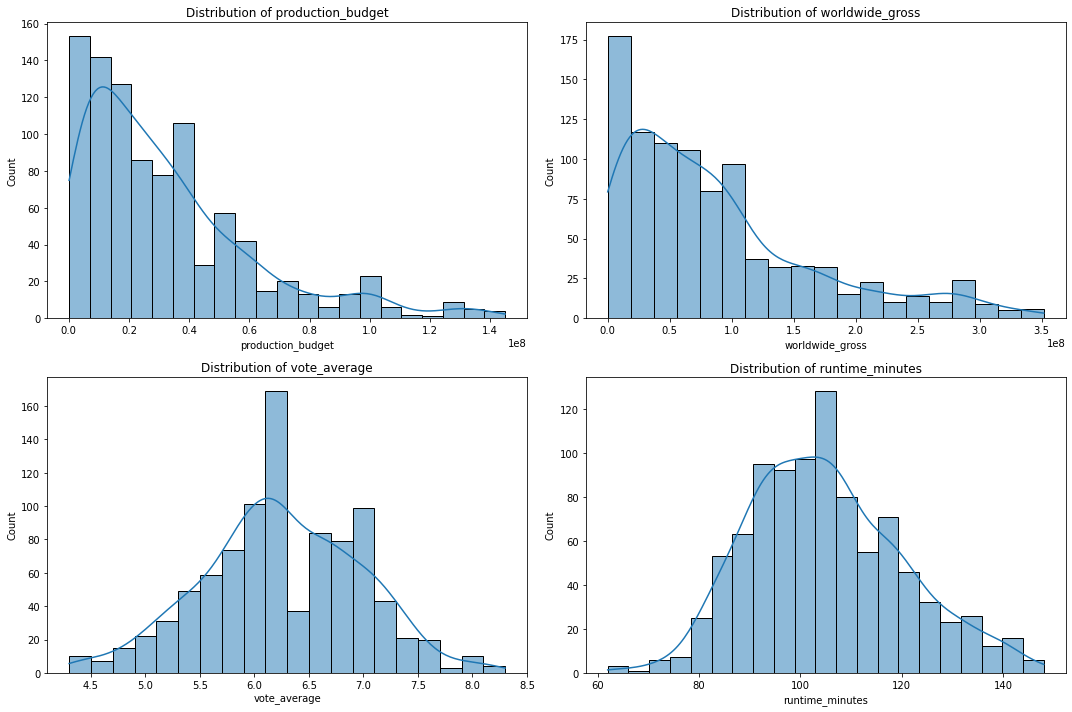

In [7]:
# Plot distributions
columns_to_plot = ['production_budget', 'worldwide_gross', 'vote_average', 'runtime_minutes']
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(columns_to_plot):
    sns.histplot(df_cleaned[col], kde=True, ax=axes[i])
    axes[i].set_title(f'Distribution of {col}')

plt.tight_layout()
plt.show()

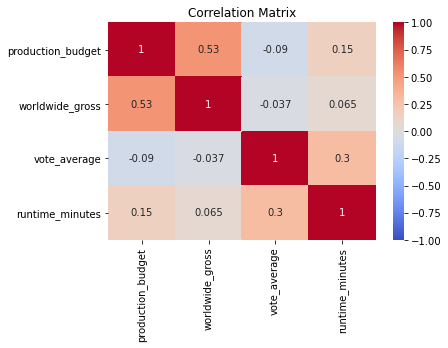

In [8]:
# Correlation matrix
corr_matrix = df_cleaned[['production_budget', 'worldwide_gross', 'vote_average', 'runtime_minutes']].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

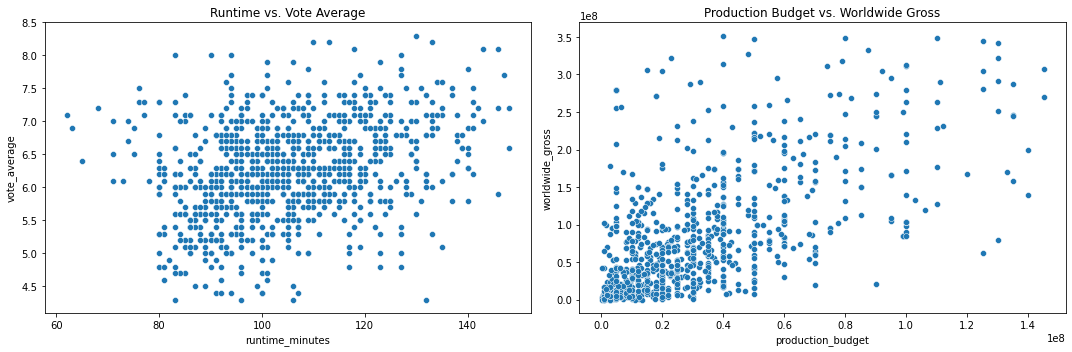

In [10]:
# Scatter plots
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# runtime vs vote_average
sns.scatterplot(data=df_cleaned, x='runtime_minutes', y='vote_average', ax=axes[0])
axes[0].set_title('Runtime vs. Vote Average')

# production_budget vs worldwide_gross
sns.scatterplot(data=df_cleaned, x='production_budget', y='worldwide_gross', ax=axes[1])
axes[1].set_title('Production Budget vs. Worldwide Gross')

plt.tight_layout()
plt.show()

Inferential Modeling

In [ ]:
#Regression Analysis: Conduct linear regression on production_budget and worldwide_gross.
# Prepare data for regression
X = df_cleaned[['production_budget']]
y = df_cleaned['worldwide_gross']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Evaluate model performance
r_squared = model.score(X_test, y_test)
coef = model.coef_
intercept = model.intercept_

print(f'R-squared: {r_squared}')
print(f'Coefficient: {coef[0]}, Intercept: {intercept}')

R-squared: 0.30243980505641366
Coefficient: 1.4229599621709275, Intercept: 42398345.282709725


Normality tests using Shapiro-Wilk test for normality

In [21]:
# Shapiro-Wilk test for normality
columns_to_test = ['production_budget', 'worldwide_gross', 'vote_average', 'runtime_minutes']

for col in columns_to_test:
    stat, p_value = shapiro(df_cleaned[col].dropna())  # Drop NaN values for testing
    print(f'>> Shapiro-Wilk test for {col}: Statistic={stat}, p-value={p_value}')
    if p_value < 0.05:
        print(f"{col} is likely not normally distributed (reject H0 at alpha=0.05).")
    else:
        print(f"{col} is likely normally distributed (fail to reject H0 at alpha=0.05).")

>> Shapiro-Wilk test for production_budget: Statistic=0.8573058843612671, p-value=2.745811803222493e-28
production_budget is likely not normally distributed (reject H0 at alpha=0.05).
>> Shapiro-Wilk test for worldwide_gross: Statistic=0.8709746599197388, p-value=4.1647449267956665e-27
worldwide_gross is likely not normally distributed (reject H0 at alpha=0.05).
>> Shapiro-Wilk test for vote_average: Statistic=0.99560546875, p-value=0.008859925903379917
vote_average is likely not normally distributed (reject H0 at alpha=0.05).
>> Shapiro-Wilk test for runtime_minutes: Statistic=0.9869632720947266, p-value=2.1279767281612294e-07
runtime_minutes is likely not normally distributed (reject H0 at alpha=0.05).


In [19]:
#Hypothesis  Testing: Test if movie runtimes affect ratings using a t-test.
# Split data by median runtime
median_runtime = df_cleaned['runtime_minutes'].median()
group1 = df_cleaned[df_cleaned['runtime_minutes'] <= median_runtime]['vote_average']
group2 = df_cleaned[df_cleaned['runtime_minutes'] > median_runtime]['vote_average']

# Perform t-test
t_stat, p_val = stats.ttest_ind(group1, group2)
print(f'T-test Statistic: {t_stat}, P-value: {p_val}')

T-test Statistic: -7.570957186358581, P-value: 8.875593957269215e-14


In [20]:
#ANOVA: CPerform ANOVA on vote_count by genre
anova_result = stats.f_oneway(*(df_cleaned[df_cleaned['genre'] == genre]['vote_count'] for genre in df_cleaned['genre'].unique()))
print(f'ANOVA F-statistic: {anova_result.statistic}, P-value: {anova_result.pvalue}')

ANOVA F-statistic: 4.937682807004767, P-value: 5.812220748703319e-08


# Comments


### EDA


#### 1. Distribution Analysis: Histograms were generated for key numeric columns—`production_budget`, `worldwide_gross`, `vote_average`, and `runtime_minutes`—to understand the spread, central tendencies, and variability in each dataset. These plots allowed us to assess potential skewness or outliers in the data.



##### - The distributions indicate that most movies have low budgets and gross revenues, receive moderate ratings, and typically have runtimes around 100 minutes, with fewer films in the higher ranges for budget, revenue, and runtime.

#### 2. Correlation Analysis: A correlation matrix and heatmap were created to explore the linear relationships among variables, particularly focusing on `production_budget` and `worldwide_gross`, `runtime_minutes` and `vote_average`, and `vote_count` across genres. This helped to highlight potential strong correlations that could guide further analysis.


##### - The correlation matrix shows a moderate positive correlation between `production_budget` and `worldwide_gross` (0.53), suggesting that higher budgets are somewhat associated with higher box office revenues, while other variables like `vote_average` and `runtime_minutes` have weak or negligible correlations with both budget and gross revenue, indicating limited linear relationships


### 3. Scatter Plot Analysis: Scatter plots for `production_budget` vs. `worldwide_gross` and `runtime_minutes` vs. `vote_average` allowed for visual insights into relationships between these variables, helping to identify any visible trends, clusters, or outliers.



##### - The scatter plots show a weak positive relationship between `runtime_minutes` and `vote_average`, indicating that movie runtime has little effect on user ratings, while `production_budget` and `worldwide_gross` exhibit a more noticeable positive trend, suggesting that higher budgets tend to correspond with higher box office revenues.


### STATISTICAL DISTRIBUTIONS

#### 1. Normality Tests: Normality of key variables was evaluated using statistical tests (Shapiro-Wilk). These tests indicated whether the variables were normally distributed, which is essential for selecting appropriate modeling techniques.

##### - `production_budget` is likely not normally distributed (reject H0 at alpha=0.05)
##### - `worldwide_gross` is likely not normally distributed (reject H0 at alpha=0.05).
##### - `vote_average` is likely not normally distributed (reject H0 at alpha=0.05).
##### - `runtime_minutes` is likely not normally distributed (reject H0 at alpha=0.05).


### INFERENTIAL MODELING

#### 1. Hypothesis Testing: A t-test was conducted to assess the relationship between `runtime_minutes` and `vote_average`, comparing ratings for movies with runtimes above and below the median. The p-value and t-statistic informed whether movie runtime significantly impacts audience ratings.

##### - Focus: Examines whether there's a significant difference in ratings between movies with longer runtimes versus those with shorter runtimes.
##### - Result: The very low p-value (8.75e-14) indicates a statistically significant difference in ratings, suggesting that movie runtime does indeed affect ratings.

#### 2. ANOVA Test: An ANOVA test compared user engagement (`vote_count`) across different genres, evaluating whether audience engagement varies significantly across genres. The F-statistic and p-value indicated if certain genres are more engaging than others.

##### - Focus: Investigates whether there are significant differences in vote counts among various movie genres.
##### - Result: The extremely low p-value (5.82e-08) signifies that there are statistically significant differences in vote counts across different genres.


##### - Both the t-test and ANOVA show statistically significant relationships, with the t-test indicating movie runtimes significantly affect ratings and ANOVA showing significant differences in vote counts by genre.

# Conclusion

### The overal conclusion is that these variables (`production_budget`, `worldwide_gross`,`vote_count`, `vote_average`, `runtime_minutes`) are statistically significant and impacts the Box Office success and that the Film Production Company should take them seriously in their planning and performance evaluation if higher revenues and user approvals are one of their main investiment objectives

Emerging Trends and Audience Preferences

# Recommendations



### 1. Consider Larger Budgets for Box Office Success
##### - Insight: The positive correlation between `production_budget` and `worldwide_gross` (0.53) suggests that movies with higher budgets tend to perform better at the box office.
##### - Recommendation: The new movie studio should focus on creating films with larger budgets, as this could increase the likelihood of higher worldwide gross revenues. They will need to balance the production costs with potential returns, ensuring that the increased budget is aligned with market trends and targeted audiences.
### 2. Focus on Movie Runtimes and User Engagement
##### - Insight: The t-test analysis shows that movie `runtime` significantly affects `vote_average` (ratings), with shorter or longer films tending to receive different ratings from audiences. The scatter plot analysis also revealed a weak positive relationship between `runtime_minutes`and `vote_average`, though the impact on ratings is relatively minor.
##### - Recommendation: For audience engagement, the studio should aim for runtimes around the median (typically around 100 minutes) to appeal to a wider range of viewers and avoid alienating potential audiences with overly long or short movies. While runtime alone may not dramatically affect box office success, it is a factor in influencing movie ratings, which can affect the movie’s reputation and long-term revenue.
### 3. Tailor Genre Selection to Maximize Audience Engagement
##### - Insight: The ANOVA test results indicate that there are statistically significant differences in `vote_count` (audience engagement) across genres, highlighting that some genres are more engaging than others.
##### - Recommendation: The studio should prioritize genres that tend to generate higher audience engagement (higher vote counts), as this can help ensure greater visibility and box office performance. Genres that typically garner more attention or fan loyalty (e.g., action, adventure, or superhero films) should be given higher priority, while niche genres might be tested with more targeted marketing strategies.

# For VIVIAN to pick from, otherwise DELETE!

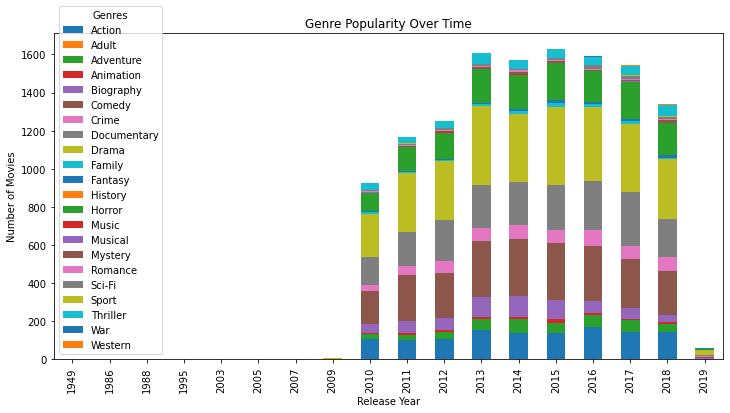

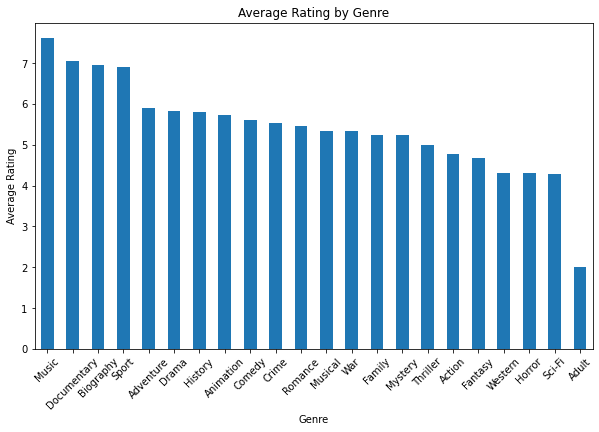

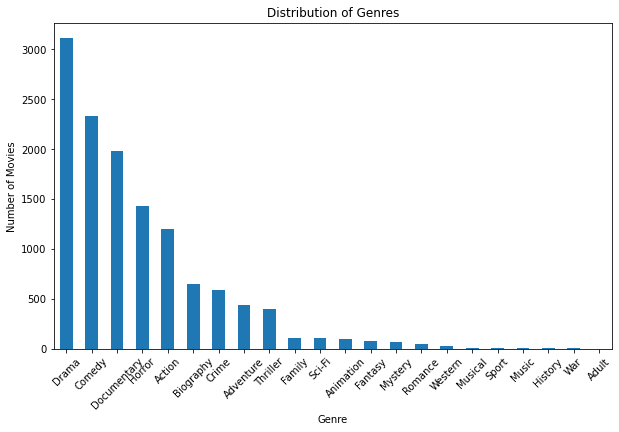

In [24]:
# Genre popularity over time (if 'release_year' is available)
# Convert 'release_date' to datetime objects
df['release_date'] = pd.to_datetime(df['release_date'])
df['release_year'] = df['release_date'].dt.year
genre_trends = df.groupby(['release_year', 'genres']).size().unstack()
genre_trends = genre_trends.dropna(how='all')
genre_trends.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Genre Popularity Over Time')
plt.xlabel('Release Year')
plt.ylabel('Number of Movies')
plt.legend(title='Genres')
plt.show()

# Top genres by average rating
plt.figure(figsize=(10, 6))
avg_rating_by_genre.plot(kind='bar')
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.xticks(rotation=45)
plt.show()


# Distribution of genres
genre_counts = df['genres'].value_counts()
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title('Distribution of Genres')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45)
plt.show()

Average Rating: 5.694340365239294
Median Rating: 5.8
Mode Rating: 6.2
Rating Standard Deviation: 1.4356452043659933


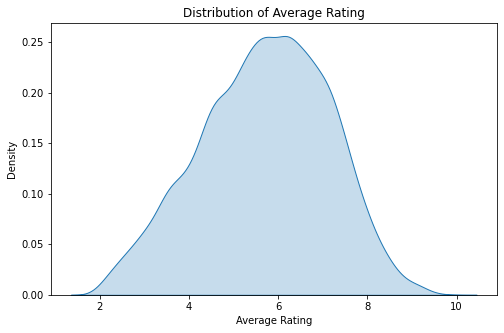

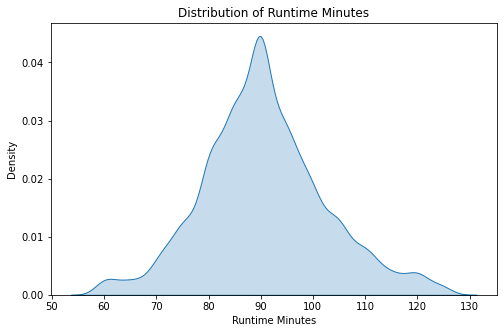

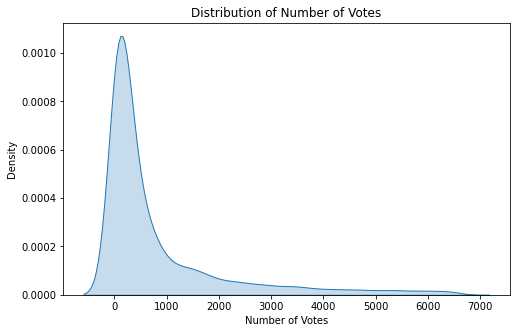

count    12704.000000
mean       839.097135
std       1312.549333
min          5.000000
25%         77.000000
50%        267.000000
75%        915.250000
max       6585.000000
Name: numvotes, dtype: float64


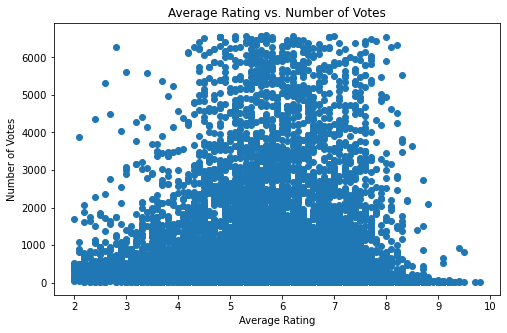

Correlation coefficient: 0.01684400710294838
T-statistic: 2.47855216222517, P-value: 0.01320457038259006
                 sum_sq       df           F  PR(>F)
C(genres)   9268.054426     21.0  330.914362     0.0
Residual   16913.808646  12682.0         NaN     NaN


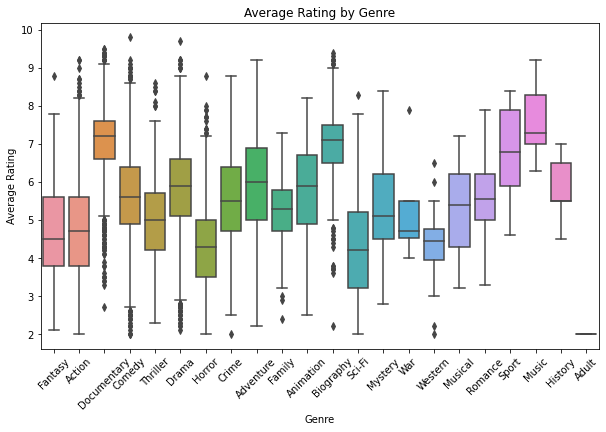

                            OLS Regression Results                            
Dep. Variable:          averagerating   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.646e+29
Date:                Wed, 13 Nov 2024   Prob (F-statistic):               0.00
Time:                        20:23:45   Log-Likelihood:             3.6141e+05
No. Observations:               12704   AIC:                        -7.228e+05
Df Residuals:                   12700   BIC:                        -7.228e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -8.882e-14   8.11e-15    -

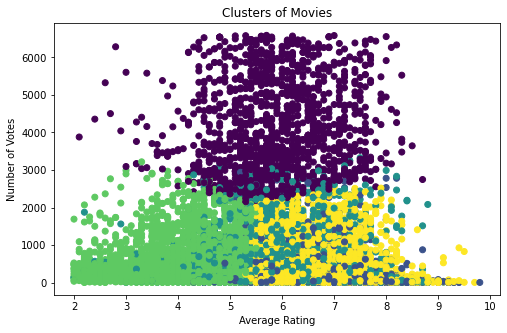

In [37]:
# Typical rating and variation
print("Average Rating:", df['averagerating'].mean())
print("Median Rating:", df['averagerating'].median())
print("Mode Rating:", df['averagerating'].mode()[0])
print("Rating Standard Deviation:", df['averagerating'].std())

# Distribution of average rating (KDE plot)
plt.figure(figsize=(8, 5))
sns.kdeplot(df['averagerating'], fill=True)
plt.title('Distribution of Average Rating')
plt.xlabel('Average Rating')
plt.ylabel('Density')
plt.show()

# Distribution of runtime_minutes (KDE plot)
plt.figure(figsize=(8, 5))
sns.kdeplot(df['runtime_minutes'], fill=True)
plt.title('Distribution of Runtime Minutes')
plt.xlabel('Runtime Minutes')
plt.ylabel('Density')
plt.show()

# Distribution of numvotes (KDE plot)
plt.figure(figsize=(8, 5))
sns.kdeplot(df['numvotes'], fill=True)
plt.title('Distribution of Number of Votes')
plt.xlabel('Number of Votes')
plt.ylabel('Density')
plt.show()


# User engagement (summary statistics of numvotes)
print(df['numvotes'].describe())

# --- Bivariate Analysis ---

# Relationship between rating and votes (scatter plot)
plt.figure(figsize=(8, 5))
plt.scatter(df['averagerating'], df['numvotes'])
plt.title('Average Rating vs. Number of Votes')
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.show()

# Correlation coefficient
correlation = df['averagerating'].corr(df['numvotes'])
print(f"Correlation coefficient: {correlation}")

# T-test for high-rated vs. low-rated movies
high_rated_votes = df[df['averagerating'] > df['averagerating'].mean()]['numvotes']
low_rated_votes = df[df['averagerating'] <= df['averagerating'].mean()]['numvotes']
t_stat, p_value = stats.ttest_ind(high_rated_votes, low_rated_votes)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# ANOVA for average rating by genre
model = ols('averagerating ~ C(genres)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Box plot of averagerating by genre
plt.figure(figsize=(10, 6))
sns.boxplot(x='genres', y='averagerating', data=df)
plt.xticks(rotation=45)
plt.title('Average Rating by Genre')
plt.xlabel('Genre')
plt.ylabel('Average Rating')
plt.show()

# --- Multivariate Analysis ---

# Prepare data
#features = ['averagerating', 'numvotes', 'runtime_minutes', 'release_year']
#X = df[features]
#X = pd.get_dummies(X, columns=['genres'], drop_first=True)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

# Regression Analysis
X_reg = sm.add_constant(X)
model = sm.OLS(df['averagerating'], X_reg).fit()
print(model.summary())

# Clustering (K-Means)
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)

# Visualize clusters (example - scatter plot)
plt.figure(figsize=(8, 5))
plt.scatter(df['averagerating'], df['numvotes'], c=df['cluster'])
plt.title('Clusters of Movies')
plt.xlabel('Average Rating')
plt.ylabel('Number of Votes')
plt.show()

Influence of User Ratings

In [28]:
# Hypothesis testing: Does average rating significantly affect number of votes?
t_stat, p_value = stats.ttest_ind(
    df[df['averagerating'] > df['averagerating'].mean()]['numvotes'],
    df[df['averagerating'] <= df['averagerating'].mean()]['numvotes']
)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

# ANOVA: Is there a significant difference in average rating between genres?
model = ols('averagerating ~ C(genres)', data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

# Chi-square test: Is there a relationship between genre and rating category (high/low)?
df['rating_category'] = pd.cut(df['averagerating'], bins=[0, df['averagerating'].mean(), 10], labels=['low', 'high'])
contingency_table = pd.crosstab(df['genres'], df['rating_category'])
chi2, p_value, dof, expected = chi2_contingency(contingency_table)
print(f"Chi-square statistic: {chi2}, P-value: {p_value}")

T-statistic: 2.47855216222517, P-value: 0.01320457038259006
                 sum_sq       df           F  PR(>F)
C(genres)   9268.054426     21.0  330.914362     0.0
Residual   16913.808646  12682.0         NaN     NaN
Chi-square statistic: 3427.542128549238, P-value: 0.0
